### Prediction of New York City Taxi Fares
In this section we will transform the dataset in order to create new useful datetime and distance features, with this new features we will try to predict with regression the fare amount of the taxi rides taking with the rest of the features less the fare class. In the second part we will try to predict the fare class using embeddings and PyTorch embedding layers for the zipcodes.

Description of the dataset

Features:
 
- pickup_datetime - timestamp value indicating when the taxi ride started.
- pickup_longitude - float for longitude coordinate of where the taxi ride started.
- pickup_latitude - float for latitude coordinate of where the taxi ride started.
- dropoff_longitude - float for longitude coordinate of where the taxi ride ended.
- dropoff_latitude - float for latitude coordinate of where the taxi ride ended.
- passenger_count - integer indicating the number of passengers in the taxi ride.

Target
- fare_amount: float dollar amount of the cost of the taxi ride. This value is only in the training set; this is what you are predicting in the test set and it is required in your submission CSV.

### Get the traveled distance with the coordinates

A Regression approach that correlates the traveled distance with the fare amount per ride needs a traveled distance calculation with the coordinates provided. For this reason a new feature could be calculated with the Haversine formula that calculates the distance on a sphere between two sets of GPS coordinates. With this, we reduce the complexity of the travel with a straight line. 

The distance formula works out to

$${\displaystyle d=2r\arcsin \left({\sqrt {\sin ^{2}\left({\frac {\varphi _{2}-\varphi _{1}}{2}}\right)+\cos(\varphi _{1})\:\cos(\varphi _{2})\:\sin ^{2}\left({\frac {\lambda _{2}-\lambda _{1}}{2}}\right)}}\right)}$$

where

$\begin{split} r&: \textrm {radius of the sphere (Earth's radius averages 6371 km)}\\
\varphi_1, \varphi_2&: \textrm {latitudes of point 1 and point 2}\\
\lambda_1, \lambda_2&: \textrm {longitudes of point 1 and point 2}\end{split}$

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import seaborn as sns

In [2]:
has_mps = torch.backends.mps.is_built()
device = "mps" if has_mps else "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
torch.manual_seed(42)
# Defining an early stopping class for PyTorch
import copy
class EarlyStopping:
  def __init__(self, patience=5, min_delta=0, restore_best_weights=True):
    self.patience = patience
    self.min_delta = min_delta
    self.restore_best_weights = restore_best_weights
    self.best_model = None
    self.best_loss = None
    self.patience_counter = 0
    self.status = ""

  def __call__(self, model, val_loss):
    if self.best_loss is None:
      self.best_loss = val_loss
      self.best_model = copy.deepcopy(model.state_dict())
    elif self.best_loss - val_loss >= self.min_delta:
      self.best_model = copy.deepcopy(model.state_dict())
      self.best_loss = val_loss
      self.status = f"Improvement!!!, actual counter {self.patience_counter}"
      self.patience_counter = 0
    else:
      self.patience_counter += 1
      self.status = f"NO improvement in the last {self.patience_counter} epochs"
      if self.patience_counter >= self.patience:
        self.status = f"Early stopping triggered after {self.patience_counter} epochs."
        if self.restore_best_weights:
          model.load_state_dict(self.best_model)
        return True
    return False

Using device: cpu


In [3]:
# read the MPG dataset
df = pd.read_csv("data/NYCTaxiFares.csv", na_values=["NA", "?"])

# check for missing values
missing_values = df.isnull().sum()
print(missing_values)

pickup_datetime      0
fare_amount          0
fare_class           0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64


### Descriptive analytics
Check for outliers with graphics

In [4]:
df['fare_amount'].describe()

count    120000.000000
mean         10.040326
std           7.500134
min           2.500000
25%           5.700000
50%           7.700000
75%          11.300000
max          49.900000
Name: fare_amount, dtype: float64

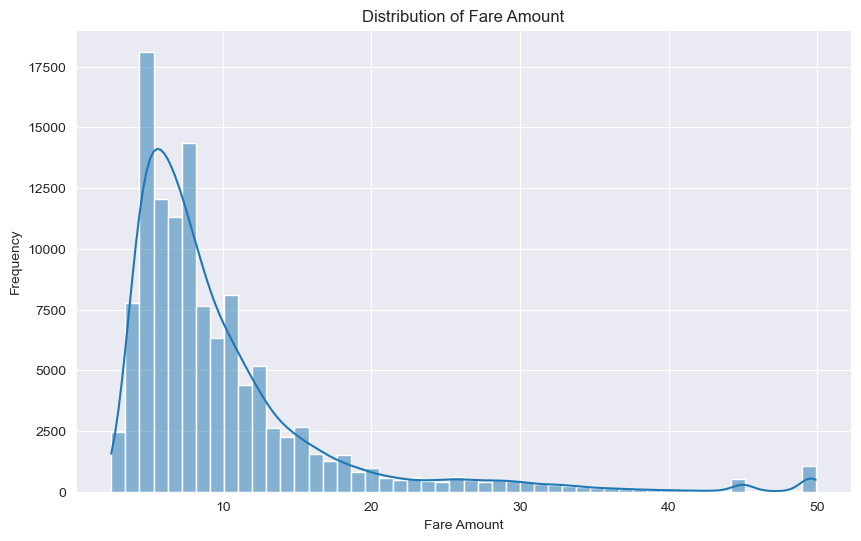

In [5]:
# Plotting the distribution of fare_amount
plt.figure(figsize=(10, 6))
sns.histplot(df['fare_amount'], bins=50, kde=True)
plt.title('Distribution of Fare Amount')
plt.xlabel('Fare Amount')
plt.ylabel('Frequency')
plt.show()

In [7]:
# function to calculate the distance of the travel
def haversine_distance(df, lat1, lon1, lat2, lon2):
    
    # average radius of the Earth in (km)
    r = 6371
    
    phi1 = np.radians(df[lat1])
    phi2 = np.radians(df[lat2])
    delta_phi = np.radians(df[lat2] - df[lat1])
    delta_lambda = np.radians(df[lon2] - df[lon1])
    
    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = (r * c)
    
    return d

In [8]:
# append a 'dist_km' new feature in the dataframe
df['dist_km'] = haversine_distance(df, 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude')


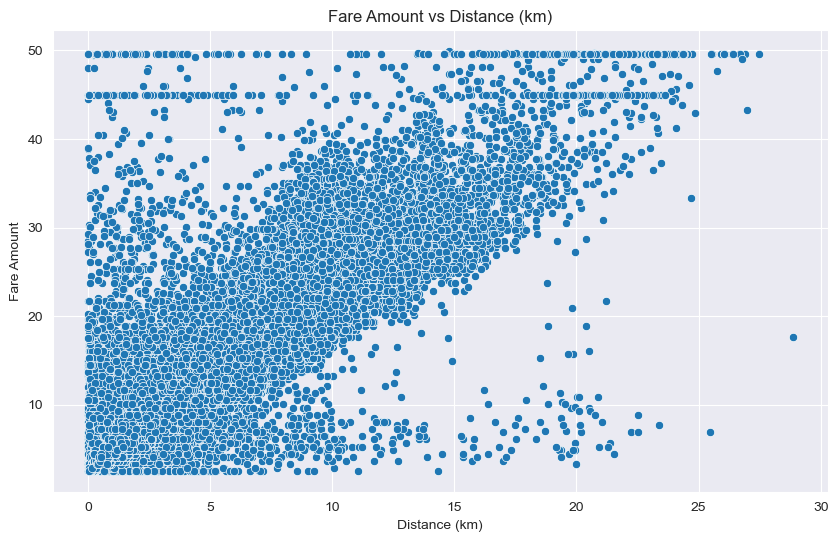

In [9]:
# Plotting the scatter plot of fare_amount vs dist_km
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['dist_km'], y=df['fare_amount'])
plt.title('Fare Amount vs Distance (km)')
plt.xlabel('Distance (km)')
plt.ylabel('Fare Amount')
plt.show()

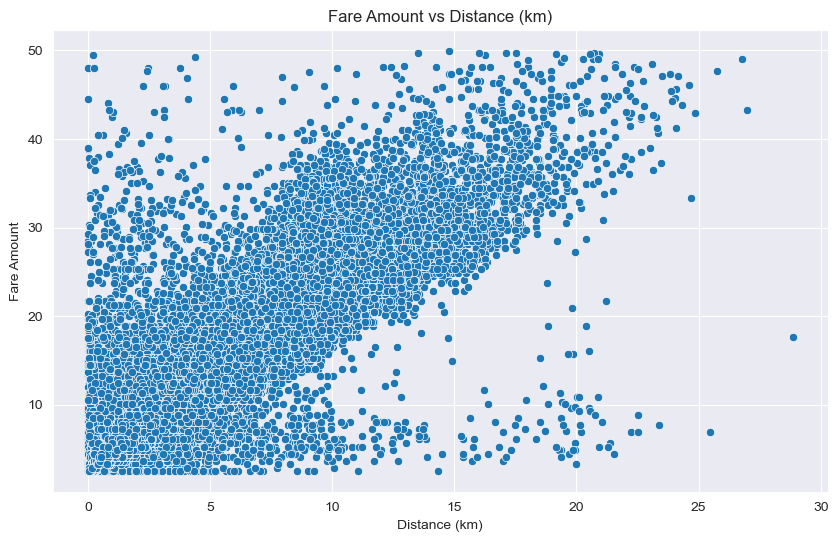

In [34]:
df = df[(df['fare_amount'] != 49.57) & (df['fare_amount'] != 45.00)]
# Plotting the scatter plot of fare_amount vs dist_km
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['dist_km'], y=df['fare_amount'])
plt.title('Fare Amount vs Distance (km)')
plt.xlabel('Distance (km)')
plt.ylabel('Fare Amount')
plt.show()

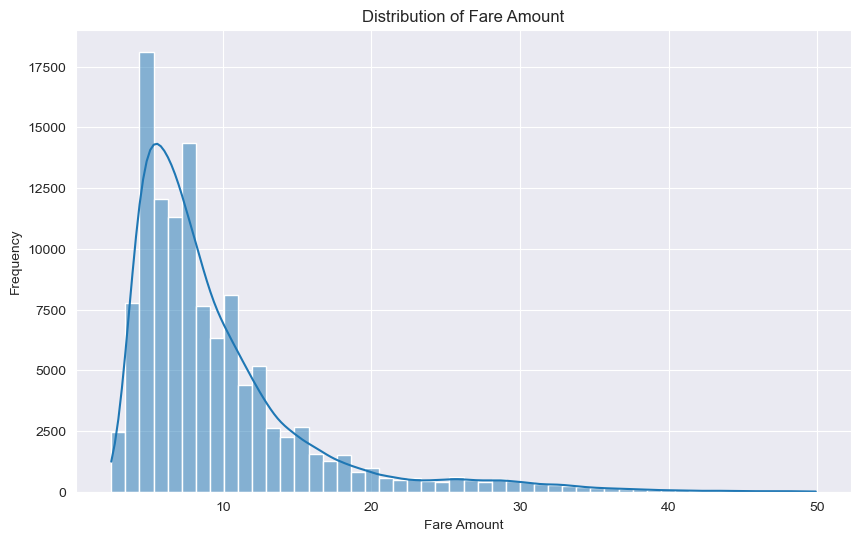

In [35]:
# Plotting the distribution of fare_amount
plt.figure(figsize=(10, 6))
sns.histplot(df['fare_amount'], bins=50, kde=True)
plt.title('Distribution of Fare Amount')
plt.xlabel('Fare Amount')
plt.ylabel('Frequency')
plt.show()

### Time datatypes transformations
To work with the special pandas dtype timestamps the to_datetime method can be used.

In [36]:
# actual dtypes
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

Correcting pickup_datetime due to daylight savings time (April) There is a 4 hour difference between the value in the dataframe and the real NYC time. Eastern Day Time.

In [37]:
df['EDTdate'] = df['pickup_datetime'] - pd.Timedelta(hours=4)

Extract new features from the time series

In [38]:
df['Hour'] = df['EDTdate'].dt.hour
df['AMorPM'] = np.where(df['Hour']<12, 'am', 'pm')
df['Weekday'] = df['EDTdate'].dt.strftime("%a")

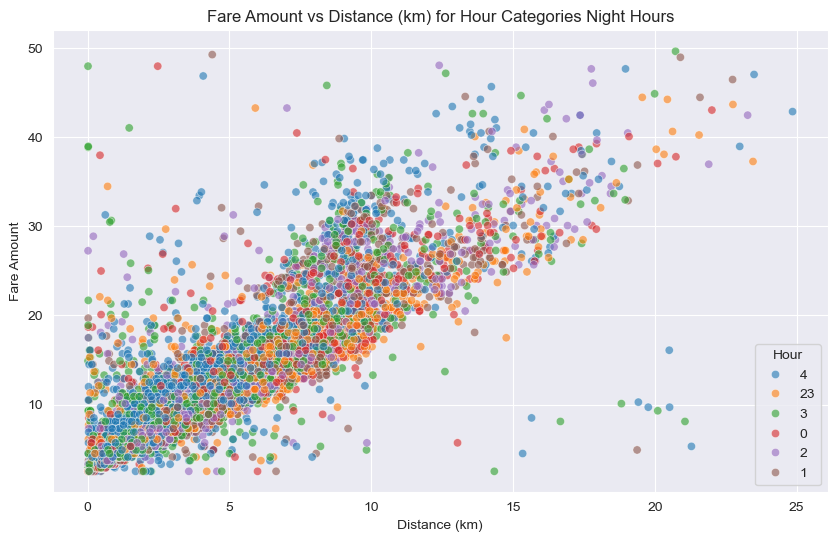

In [39]:
# Filter the dataframe to include only rows of Night Hours
df_filtered = df[df['Hour'].isin([23,0,1,2,3,4])]

# Plotting the scatter plot of fare_amount vs dist_km colored by Night Hours
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_filtered['dist_km'], y=df_filtered['fare_amount'], hue=df_filtered['Hour'].astype(str), alpha=0.6)
plt.title('Fare Amount vs Distance (km) Night Hours categories')
plt.xlabel('Distance (km)')
plt.ylabel('Fare Amount')
plt.legend(title='Hour')
plt.show()

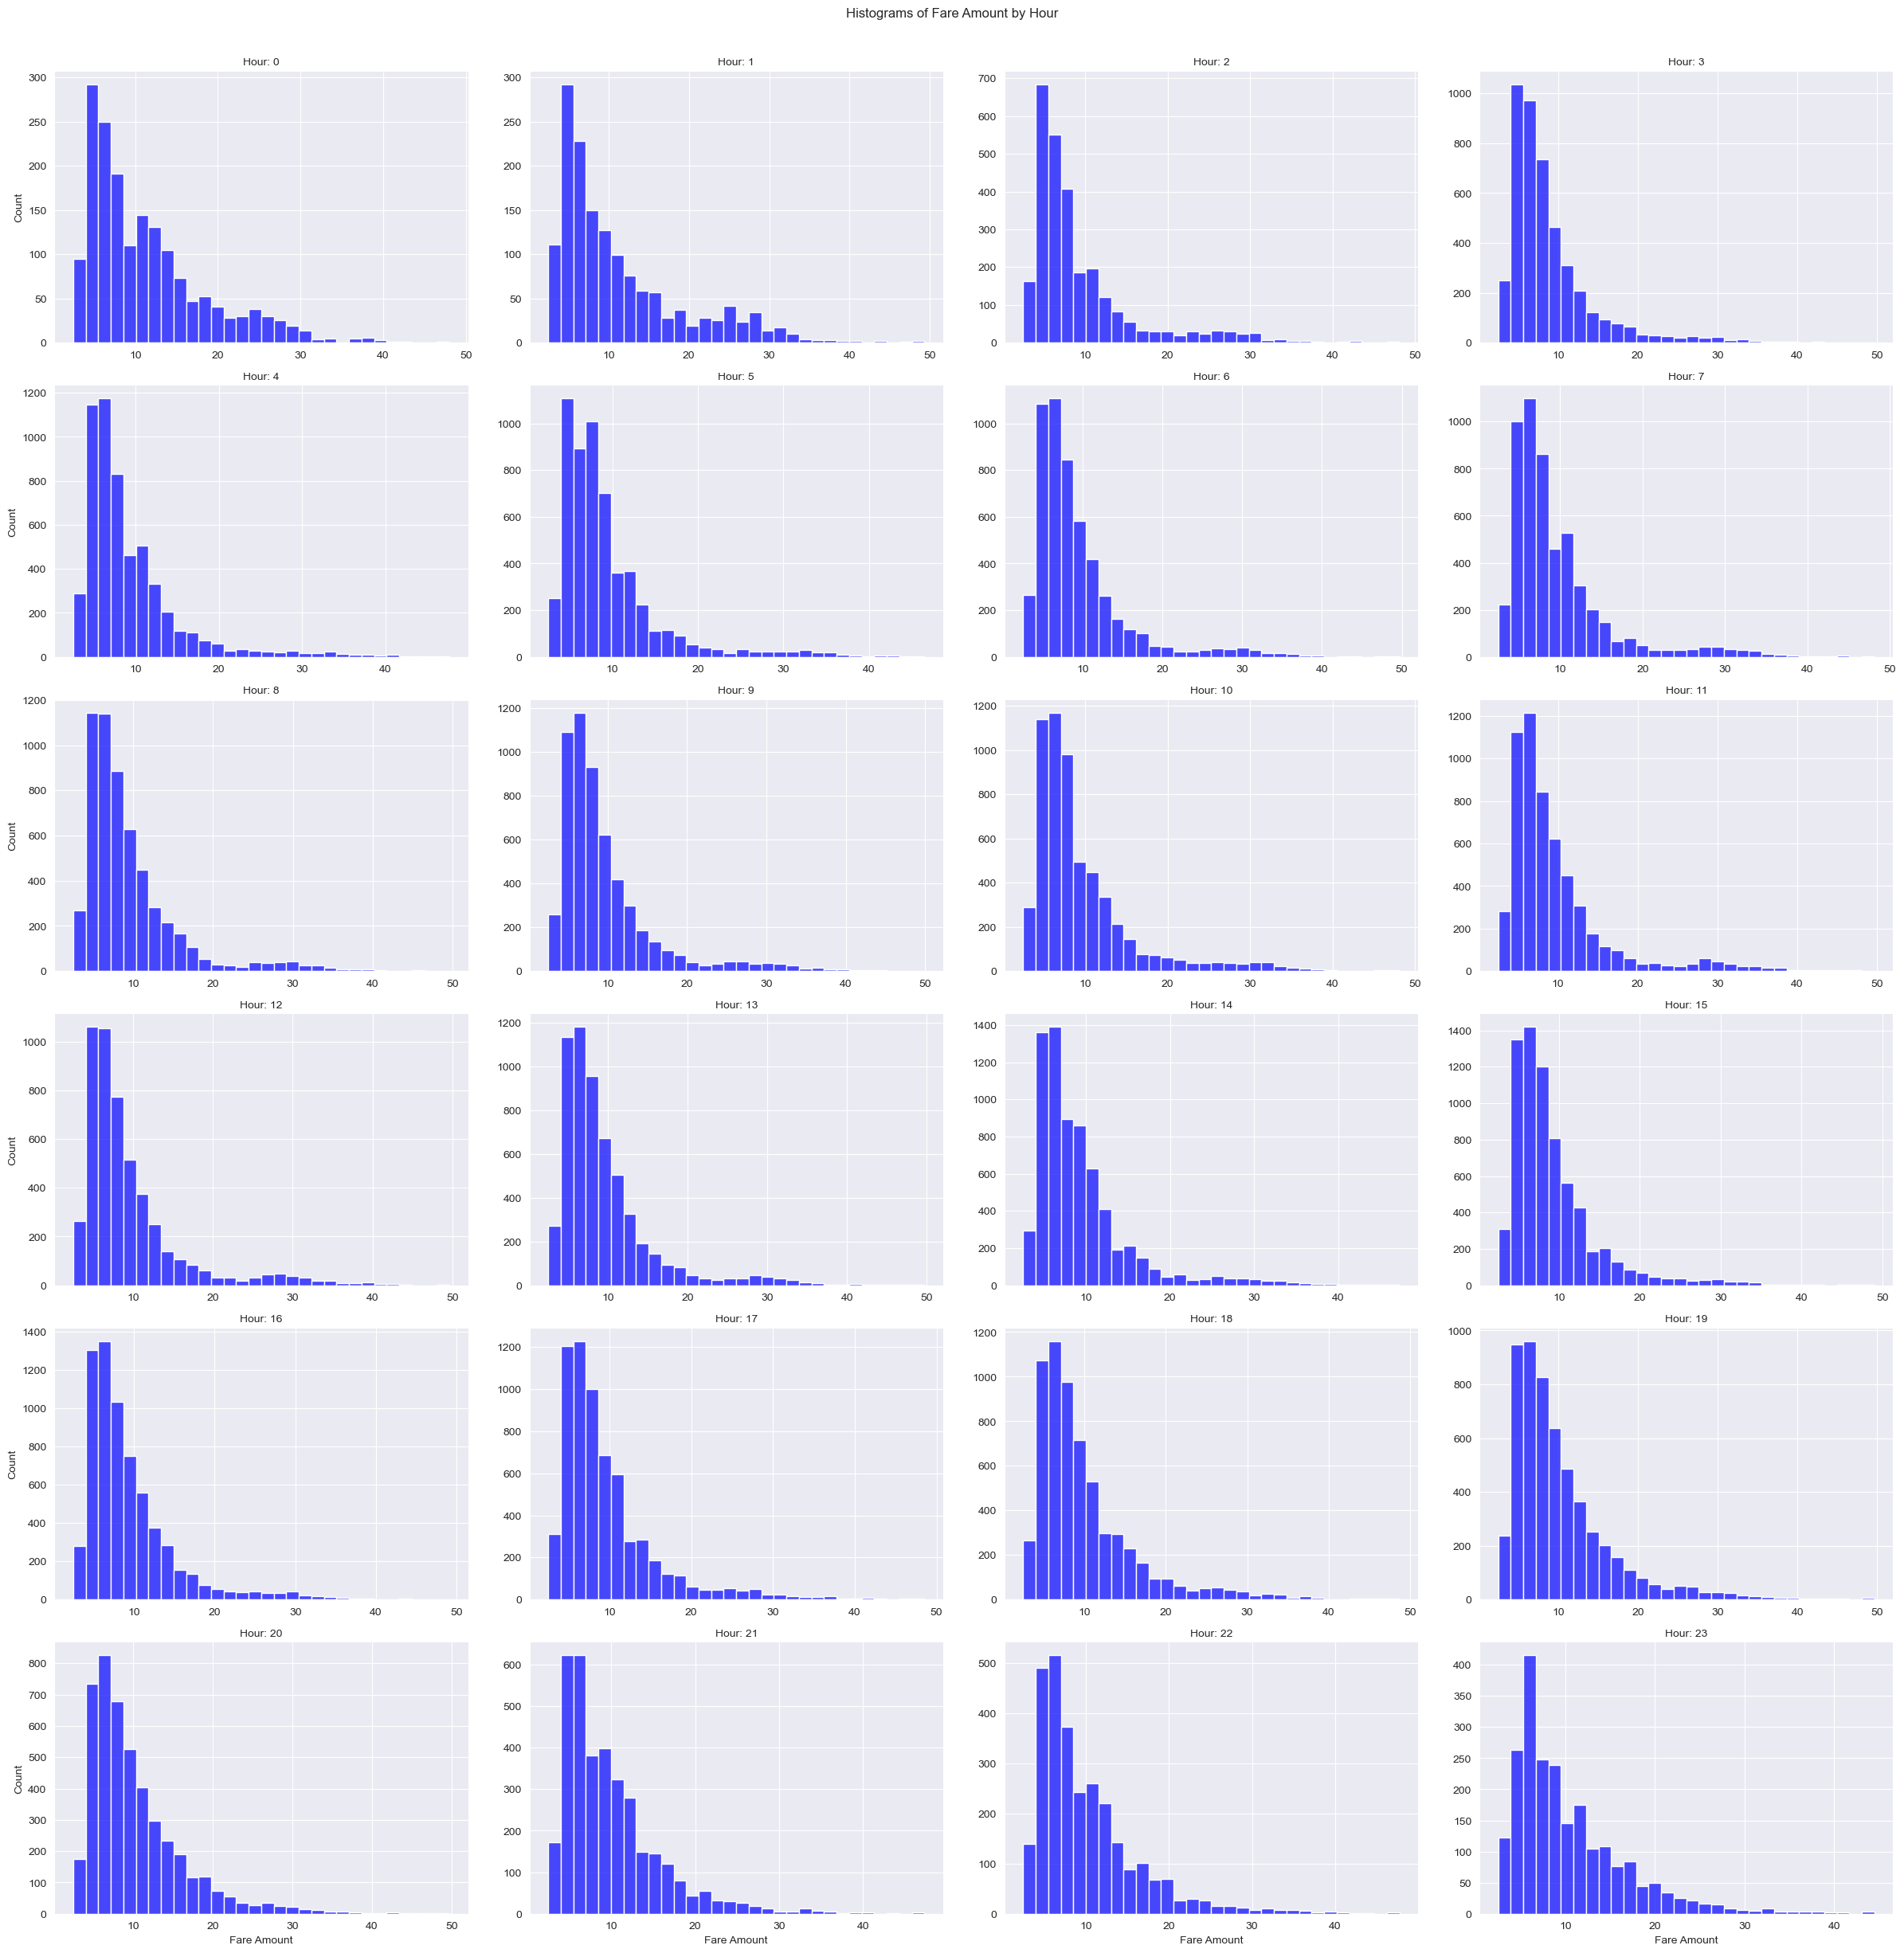

In [40]:
# Create a FacetGrid to plot histograms for each 'Hour' category
g = sns.FacetGrid(df, col='Hour', col_wrap=4, height=4, aspect=1.5, sharex=False, sharey=False)
g.map(sns.histplot, 'fare_amount', kde=False, bins=30, color='blue', alpha=0.7)

# Add titles and labels
g.set_titles(col_template='Hour: {col_name}')
g.set_axis_labels('Fare Amount', 'Count')
g.fig.suptitle('Histograms of Fare Amount by Hour', y=1.02)

plt.show()

### Managing categorical and continuous values in Pandas
Defining arbitrary continuous categories, arbitrary continuous columns and the target feature

In [ ]:
df.columns

In [ ]:
cat_cols = ['Hour', 'AMorPM', 'Weekday']
cont_cols = ['passenger_count', 'dist_km']

# target feature for regression task
y_col = ['fare_amount']

How to know the pandas category dtype

In [ ]:
df.dtypes

Convert pandas dtypes

In [ ]:
for cat in cat_cols:
    df[cat] = df[cat].astype('category')

df.dtypes

In [ ]:
# list the categories inside a pandas categorical field
df['AMorPM'].cat.categories

In [ ]:
# return a numpy array with the codes that corresponds to each category in the pd field
hr = df['Hour'].cat.codes.values
ampm = df['AMorPM'].cat.codes.values
wkdy = df['Weekday'].cat.codes.values
print(hr, ampm, wkdy)

In [ ]:
# stack together in a single array matrix
cats = np.stack([hr, ampm, wkdy], axis=1)
cats

In [ ]:
# create categorical codes matrix with list comprehension
cats_l = np.stack([df[col].cat.codes.values for col in cat_cols], axis=1)
cats

In [ ]:
# create continuous matrix with list comprehension
conts_l = np.stack([df[col].values for col in cont_cols], axis=1)

### PyTorch features and target tensors

In [ ]:
# create categorical tensor
cats = torch.tensor(cats_l, dtype=torch.int32)

# create continuous tensor
conts = torch.tensor(conts_l, dtype=torch.float32)

# create label (y) tensor
y = torch.tensor(df[y_col].values, dtype=torch.float32)

In [ ]:
# categorical sizes list
cat_sizes = [len(df[col].cat.categories) for col in cat_cols]
cat_sizes

In [ ]:
# embedding sizes list (divide the number of unique entries in each column by two, if the result is grather than 50 select 50)
emb_sizes = [(size, min(50,(size+1)//2)) for size in cat_sizes]
emb_sizes

### Illustration of how will be trated the embedings inside the "Tabular model". The name "Tabular Model" comes from the fastai library and documentation https://docs.fast.ai/tabular.model.html

In [ ]:
# take a sample of the categorigal tensor
cat_sample = cats[:2]
cat_sample

In [ ]:
# with the embedding sizes list create torch embedding layers and store them in a ModuleList
# modulelist is an iterator
def create_emb_layers(emb_sizes):
    mod_list = []
    for ni, nf in emb_sizes:
      mod_list.append(nn.Embedding(ni, nf))

    self_embeddings = nn.ModuleList(mod_list)
    return self_embeddings

self_embeddings = create_emb_layers(emb_sizes)
self_embeddings

In [ ]:
# list comprehension version for create embedding layers
self_embeddings = nn.ModuleList([nn.Embedding(ni, nf) for ni, nf in emb_sizes])
self_embeddings

In [ ]:
# recreation of the forward method
embeddings_sample = []
for i,e in enumerate(self_embeddings):
    embeddings_sample.append(e(cat_sample[:,i]))
embeddings_sample

In [ ]:
emb_sample = []
for i,e in enumerate(self_embeddings):
    emb_sample.append(cat_sample[:,i])
emb_sample

In [ ]:
# concatenate the embedded tensors by row
z = torch.cat(embeddings_sample, 1)
z

### Tabular model definition

In [ ]:
class TabularModel(nn.Module):
    def __init__(self, emb_sizes_s, n_cont, out_sizes, layers, p=0.5):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni, nf in emb_sizes_s])
        self.emb_drop = nn.Dropout(p)
        self.batch_norm_cont = nn.BatchNorm1d(n_cont)
        
        layer_list = []
        n_emb = sum([nf for ni, nf in emb_sizes_s])
        n_in = n_emb + n_cont
        for i in layers:
            layer_list.append(nn.Linear(n_in, i))
            layer_list.append(nn.ReLU(inplace=True))
            layer_list.append(nn.BatchNorm1d(i))
            layer_list.append(nn.Dropout(p))
            n_in = i
            
        layer_list.append(nn.Linear(layers[-1], out_sizes))
        """In Python, the asterisk (*) operator is used for unpacking a list or a tuple. When you use it in the instruction self.layers = nn.Sequential(*layer_list), it effectively unpacks the elements of layer_list and passes them as individual arguments to the nn.Sequential constructor"""
        self.layers = nn.Sequential(*layer_list)
    
    def forward(self, x_cat, x_cont):
        embeddings = []
        for i, e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:, i]))
        
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)
        
        x_cont = self.batch_norm_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        x = self.layers(x)
        return x

### Training instances and datasets

In [ ]:
# model and early stop instances
model = TabularModel(emb_sizes, conts.shape[1], 1, [200, 100], p=0.4).to(device)
early_stop = EarlyStopping(patience=40)

In [ ]:
# combining categorical and continuous tensors for shuffling
combined = torch.cat([cats, conts, y], dim=1)

# torch to numpy array
combined = combined.numpy()

# splitting the combined data into train and test sets
train_data, test_data = tra